In [1]:
import pickle
import json
import pandas as pd
import numpy as np
import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Reading data and Preparing it

In [2]:
# reading data
c2g_data = pd.read_csv('data/interpol/c2g_interpol_demand.csv', index_col=0)

def read_pickle(path):
    infile = open(path,'rb')
    file = pickle.load(infile)
    infile.close()
    return file

lgb_multimodel = read_pickle(r'models/c2g_model_light_gbm.sav')
lgb_unimodel = read_pickle(r'models/unic2g_model_light_gbm.sav')
cat_multimodel = read_pickle(r'models/c2g_model_catboost.sav')
cat_unimodel = read_pickle(r'models/unic2g_model_catboost.sav')

with open(r'models/LightGBM_Data_Parameters.json') as f:
    data_lgb_parameters = json.load(f)
    
with open(r'models/Catboost_Data_Parameters.json') as f:
    data_cat_parameters = json.load(f)
    
if(data_cat_parameters == data_lgb_parameters):
    params = data_cat_parameters
else:
    print("The parameters on the data must be the same")
    print(data_cat_parameters)
    print(data_lgb_parameters)
    params = {}

In [38]:
c2g_data.columns

Index(['tempC', 'precipMM', 'FeelsLikeC', 'uvIndex', 'visibility',
       'windspeedMiles', 'Blizzard', 'Clear', 'Cloudy', 'Fog', 'Heavy rain',
       'Heavy rain at times', 'Heavy snow', 'Light drizzle', 'Light rain',
       'Light rain shower', 'Light sleet', 'Light sleet showers', 'Light snow',
       'Mist', 'Moderate or heavy freezing rain',
       'Moderate or heavy rain shower', 'Moderate or heavy rain with thunder',
       'Moderate or heavy sleet', 'Moderate or heavy snow showers',
       'Moderate or heavy snow with thunder', 'Moderate rain',
       'Moderate rain at times', 'Moderate snow', 'Overcast', 'Partly cloudy',
       'Patchy heavy snow', 'Patchy light drizzle', 'Patchy light rain',
       'Patchy light rain with thunder', 'Patchy light snow',
       'Patchy moderate snow', 'Patchy rain possible', 'Patchy sleet possible',
       'Patchy snow possible', 'Sunny', 'Thundery outbreaks possible',
       'Torrential rain shower', 'Monday', 'Tuesday', 'Wednesday', 'Thursday

In [39]:
c2g_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'interpolate'], inplace=True)

In [40]:
params

{'TIME_FRAME_START': '2016-12-13 15:00:00',
 'TIME_FRAME_FINISH': '2017-02-25 17:00:00',
 'TRAIN_VAL_SPLIT': 0.6,
 'VAL_TEST_SPLIT': 0.8,
 'PAST_LAGS': 24,
 'FUTURE_LAGS': 12}

In [41]:
c2g_data.index = pd.to_datetime(c2g_data.index)

c2g_data = c2g_data.loc[params["TIME_FRAME_START"]:params["TIME_FRAME_FINISH"]]

In [42]:
def undo_one_hot(df, new_col_name, columns = []):
    new_df = df.copy().drop(columns=columns)
    
    def get_cat(row):
        for c in df.loc[:, columns].columns:
            if row[c]==1:
                return c
            
    new_df[new_col_name] = pd.Categorical(df.apply(get_cat, axis=1))
    
    return new_df

In [43]:
c2g_data = undo_one_hot(c2g_data, 'Weather', columns=['Blizzard', 'Clear', 'Cloudy', 'Fog', 'Heavy rain',
       'Heavy rain at times', 'Heavy snow', 'Light drizzle', 'Light rain',
       'Light rain shower', 'Light sleet', 'Light sleet showers', 'Light snow',
       'Mist', 'Moderate or heavy freezing rain',
       'Moderate or heavy rain shower', 'Moderate or heavy rain with thunder',
       'Moderate or heavy sleet', 'Moderate or heavy snow showers',
       'Moderate or heavy snow with thunder', 'Moderate rain',
       'Moderate rain at times', 'Moderate snow', 'Overcast', 'Partly cloudy',
       'Patchy heavy snow', 'Patchy light drizzle', 'Patchy light rain',
       'Patchy light rain with thunder', 'Patchy light snow',
       'Patchy moderate snow', 'Patchy rain possible', 'Patchy sleet possible',
       'Patchy snow possible', 'Sunny', 'Thundery outbreaks possible',
       'Torrential rain shower'])
c2g_data = undo_one_hot(c2g_data, 'Weekday', columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday'])
c2g_data.head()

,tempC,precipMM,FeelsLikeC,uvIndex,visibility,windspeedMiles,travels,Weather,Weekday
2016-12-13 15:00:00,-2,0.0,-2,1,10,5,120.0,Sunny,Tuesday
2016-12-13 16:00:00,-2,0.0,-3,1,10,6,156.0,Sunny,Tuesday
2016-12-13 17:00:00,-2,0.0,-4,1,10,6,167.0,Sunny,Tuesday
2016-12-13 18:00:00,-3,0.0,-4,1,10,6,154.0,Sunny,Tuesday
2016-12-13 19:00:00,-3,0.0,-5,1,10,7,174.0,Clear,Tuesday


In [44]:
unic2g_data = pd.DataFrame(c2g_data.travels)
unic2g_data.head()

,travels
2016-12-13 15:00:00,120.0
2016-12-13 16:00:00,156.0
2016-12-13 17:00:00,167.0
2016-12-13 18:00:00,154.0
2016-12-13 19:00:00,174.0


In [45]:
def gen_supervised_learning(df, past_lags, future_lags):
    X = df.copy()
    for lag in range(1, past_lags):
        X = X.join(df.shift(lag), rsuffix=f'_t-{lag}')
    
    y = pd.DataFrame(df.travels.copy())
    for lag in range(1, future_lags):
        y = y.join(df.travels.shift(lag), rsuffix=f'_t-{lag}')
        
    X = X.shift(future_lags)
    
    return X.iloc[past_lags + future_lags:], y.iloc[past_lags + future_lags:]

In [46]:
X, y = gen_supervised_learning(c2g_data, params['PAST_LAGS'], 1)

In [47]:
X_uni, y_uni = gen_supervised_learning(unic2g_data, params['PAST_LAGS'], 1)

In [48]:
X_12fut, y_12fut = gen_supervised_learning(unic2g_data, params['PAST_LAGS'], params['FUTURE_LAGS'])

In [49]:
X_week, y_week = gen_supervised_learning(unic2g_data, params['PAST_LAGS'], 168)

In [50]:
def splitter(data, ratio):
    size = len(data)
    data_train = data.iloc[:int(ratio[0]*size)]
    data_val = data.iloc[int(ratio[0]*size):int(ratio[1]*size)]
    data_test = data.iloc[int(ratio[1]*size):]
    return data_train, data_val, data_test

In [51]:
X_train, X_val, X_test = splitter(X, [params['TRAIN_VAL_SPLIT'], params['VAL_TEST_SPLIT']])
y_train, y_val, y_test = splitter(y, [params['TRAIN_VAL_SPLIT'], params['VAL_TEST_SPLIT']])

X_uni_train, X_uni_val, X_uni_test = splitter(X_uni, [params['TRAIN_VAL_SPLIT'], params['VAL_TEST_SPLIT']])
y_uni_train, y_uni_val, y_uni_test = splitter(y_uni, [params['TRAIN_VAL_SPLIT'], params['VAL_TEST_SPLIT']])

X_12fut_train, X_12fut_val, X_12fut_test = splitter(X_12fut, [params['TRAIN_VAL_SPLIT'], params['VAL_TEST_SPLIT']])
y_12fut_train, y_12fut_val, y_12fut_test = splitter(y_12fut, [params['TRAIN_VAL_SPLIT'], params['VAL_TEST_SPLIT']])

X_week_train, X_week_val, X_week_test = splitter(X_week, [params['TRAIN_VAL_SPLIT'], params['VAL_TEST_SPLIT']])
y_week_train, y_week_val, y_week_test = splitter(y_week, [params['TRAIN_VAL_SPLIT'], params['VAL_TEST_SPLIT']])

In [52]:
y_12fut_test

,travels,travels_t-1,travels_t-2,travels_t-3,travels_t-4,travels_t-5,travels_t-6,travels_t-7,travels_t-8,travels_t-9,travels_t-10,travels_t-11
2017-02-11 05:00:00,80.0,125.0,151.0,189.0,219.0,288.0,283.0,206.0,246.0,223.0,160.0,153.0
2017-02-11 06:00:00,54.0,80.0,125.0,151.0,189.0,219.0,288.0,283.0,206.0,246.0,223.0,160.0
2017-02-11 07:00:00,28.0,54.0,80.0,125.0,151.0,189.0,219.0,288.0,283.0,206.0,246.0,223.0
2017-02-11 08:00:00,21.0,28.0,54.0,80.0,125.0,151.0,189.0,219.0,288.0,283.0,206.0,246.0
2017-02-11 09:00:00,18.0,21.0,28.0,54.0,80.0,125.0,151.0,189.0,219.0,288.0,283.0,206.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-25 13:00:00,209.0,123.0,74.0,37.0,19.0,24.0,28.0,68.0,121.0,187.0,226.0,285.0
2017-02-25 14:00:00,212.0,209.0,123.0,74.0,37.0,19.0,24.0,28.0,68.0,121.0,187.0,226.0
2017-02-25 15:00:00,214.0,212.0,209.0,123.0,74.0,37.0,19.0,24.0,28.0,68.0,121.0,187.0
2017-02-25 16:00:00,236.0,214.0,212.0,209.0,123.0,74.0,37.0,19.0,24.0,28.0,68.0,121.0


In [53]:
c2g_data.loc["2017-02-11 05:00:00"]

tempC                         2
precipMM                      0
FeelsLikeC                    1
uvIndex                       1
visibility                   10
windspeedMiles                3
travels                      80
Weather           Partly cloudy
Weekday                Saturday
Name: 2017-02-11 05:00:00, dtype: object

## Evaluations

In [54]:
def eval_model(y, y_hat):
    evaluation = {}
    evaluation["RMSE"] = np.sqrt(mean_squared_error(y, y_hat))
    evaluation["MAE"] = mean_absolute_error(y, y_hat)
    evaluation["R2"] = r2_score(y, y_hat)

    return evaluation

### Univariable Single-Step Evaluation

In [55]:
y_hat_test_lgb = lgb_unimodel.predict(X_uni_test)
y_hat_test_cat = cat_unimodel.predict(X_uni_test)

unilgb_eval = eval_model(y_test, y_hat_test_lgb)
unicat_eval = eval_model(y_test, y_hat_test_cat)

eval_uni_ss = pd.DataFrame([unilgb_eval, unicat_eval], index=['LightGBM', 'CatBoost'])
eval_uni_ss

,RMSE,MAE,R2
LightGBM,25.096804,18.131684,0.939421
CatBoost,27.781705,19.544919,0.925766


### Multivariable Single-Step Evaluation

In [56]:
y_hat_test_lgb = lgb_multimodel.predict(X_test)
y_hat_test_cat = cat_multimodel.predict(X_test)

lgb_eval = eval_model(y_test, y_hat_test_lgb)
cat_eval = eval_model(y_test, y_hat_test_cat)

eval_multi_ss = pd.DataFrame([lgb_eval, cat_eval], index=['LightGBM', 'CatBoost'])
eval_multi_ss

,RMSE,MAE,R2
LightGBM,24.724837,17.914405,0.941204
CatBoost,28.687290,20.443632,0.920848


In [57]:
np.flip(np.arange(1,10).reshape([3,3]), axis=0)

array([[7, 8, 9],
       [4, 5, 6],
       [1, 2, 3]])

### Univariable Multi-Step Evaluation

In [66]:
def predict_n(model, data, n):
    all_results = []
    current_data = data.values.copy()
    for _ in range(n):
        prediction = model.predict(current_data)
        all_results.append(prediction)
        current_data[:,1:] = current_data[:,:-1]
        current_data[:,1] = prediction
    return np.array(all_results).T

In [67]:
y_hat_test_lgb = predict_n(lgb_unimodel, X_12fut_test, params['FUTURE_LAGS'])
y_hat_test_cat = predict_n(cat_unimodel, X_12fut_test, params['FUTURE_LAGS'])

unilgb_eval = eval_model(y_12fut_test, y_hat_test_lgb)
unicat_eval = eval_model(y_12fut_test, y_hat_test_cat)

eval_uni_ms = pd.DataFrame([unilgb_eval, unicat_eval], index=['LightGBM', 'CatBoost'])
eval_uni_ms

,RMSE,MAE,R2
LightGBM,122.213609,102.693682,-0.432131
CatBoost,119.529035,99.854255,-0.370599


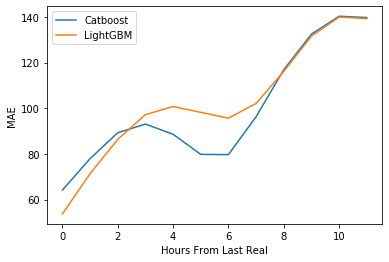

In [68]:
# Now I will get the MAE per lag
plt.plot(np.flip(mean_absolute_error(y_12fut_test, y_hat_test_cat, multioutput="raw_values")), label="Catboost")
plt.plot(np.flip(mean_absolute_error(y_12fut_test, y_hat_test_lgb, multioutput="raw_values")), label="LightGBM")
plt.legend()
plt.xlabel("Hours From Last Real")
plt.ylabel("MAE")
plt.show()

In [69]:
catboost_array = np.array([y_hat_test_cat, y_12fut_test])
np.save(f'results/Magazine Results/CatBoost_12Hrs_Predictions.npy', catboost_array)

lightgbm_array = np.array([y_hat_test_lgb, y_12fut_test])
np.save(f'results/Magazine Results/LightGBM_12Hrs_Predictions.npy', lightgbm_array)

### Univariable One Week From Now

In [70]:
y_hat_test_lgb = predict_n(lgb_unimodel, X_week_test, 168)
y_hat_test_cat = predict_n(cat_unimodel, X_week_test, 168)

weeklgb_eval = eval_model(y_week_test, y_hat_test_lgb)
weekcat_eval = eval_model(y_week_test, y_hat_test_cat)

eval_week = pd.DataFrame([weeklgb_eval, weekcat_eval], index=['LightGBM', 'CatBoost'])
eval_week

,RMSE,MAE,R2
LightGBM,118.350877,94.780367,-0.582197
CatBoost,119.081366,95.741746,-0.602962


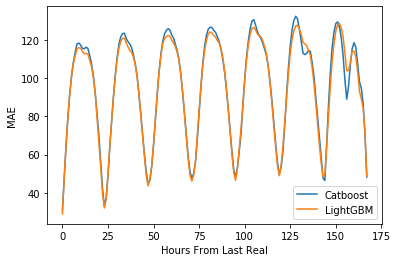

In [71]:
# Now I will get the MAE per lag
plt.plot(np.flip(mean_absolute_error(y_week_test, y_hat_test_cat, multioutput="raw_values")), label="Catboost")
plt.plot(np.flip(mean_absolute_error(y_week_test, y_hat_test_lgb, multioutput="raw_values")), label="LightGBM")
plt.legend()
plt.xlabel("Hours From Last Real")
plt.ylabel("MAE")
plt.show()

In [28]:
mean_absolute_error(y_week_test, y_hat_test_cat, multioutput="raw_values")

array([ 44.65131042,  51.45249902,  66.54154315,  81.90404669,
        96.26653496, 107.16256767, 115.40530371, 121.67226706,
       125.709146  , 127.23537065, 126.61485165, 127.03216453,
       130.58018138, 134.78545235, 136.6642165 , 136.35257555,
       133.37944405, 128.42699749, 119.65870504, 109.31308355,
        95.96464875,  81.26550895,  67.84628235,  53.48520971,
        44.2474249 ,  50.14033218,  62.60534349,  77.47817109,
        91.11613096, 101.98047222, 111.9536617 , 119.2531445 ,
       124.25833491, 127.38965218, 128.8658632 , 128.65175352,
       129.7521202 , 131.82177714, 133.2734679 , 132.16450027,
       128.4198261 , 123.12470076, 114.93543511, 104.03084234,
        91.18624395,  78.15431811,  66.41001288,  56.22472786,
        48.624355  ,  53.13096343,  64.03093155,  76.07247109,
        88.65131659,  99.52321562, 108.72664477, 116.2839218 ,
       121.45610024, 125.22384099, 127.37178321, 127.71325119,
       127.47647817, 128.54453322, 129.82347396, 128.95

In [29]:
catboost_array = np.array([y_hat_test_cat, y_week_test])
np.save(f'results/Magazine Results/CatBoost_Week_Predictions.npy', catboost_array)

lightgbm_array = np.array([y_hat_test_lgb, y_week_test])
np.save(f'results/Magazine Results/LightGBM_Week_Predictions.npy', lightgbm_array)

In [30]:
lgb_eval = pd.DataFrame({
    "1 Hour Univariable Evaluation": eval_uni_ss.iloc[0],
    "1 Hour Multivariable Evaluation": eval_multi_ss.iloc[0],
    "12 Hours Univariable Evaluation": eval_uni_ms.iloc[0],
    "168 Hours Evaluation": eval_week.iloc[0] 
}).T

cat_eval = pd.DataFrame({
    "1 Hour Univariable Evaluation": eval_uni_ss.iloc[1],
    "1 Hour Multivariable Evaluation": eval_multi_ss.iloc[1],
    "12 Hours Univariable Evaluation": eval_uni_ms.iloc[1],
    "168 Hours Evaluation": eval_week.iloc[1] 
}).T

boosting_eval = pd.concat([lgb_eval, cat_eval], keys=["LightGBM", "Catboost"])
boosting_eval.to_csv(f'results/Magazine Results/Boosting_Evaluations.csv')
boosting_eval

RMSE        MAE        R2
LightGBM 1 Hour Univariable Evaluation     25.096804  18.131684  0.939421
         1 Hour Multivariable Evaluation   24.724837  17.914405  0.941204
         12 Hours Univariable Evaluation   99.362132  79.347907  0.053959
         168 Hours Evaluation             116.446974  92.475321 -0.512515
Catboost 1 Hour Univariable Evaluation     27.781705  19.544919  0.925766
         1 Hour Multivariable Evaluation   28.687290  20.443632  0.920848
         12 Hours Univariable Evaluation   82.352569  66.280142  0.350052
         168 Hours Evaluation             115.304079  91.062502 -0.474121